# Spotify's song analysis

This is a personal project that aims to profile my favorite artists and songs on Spotify over months (from May 2019 to October 2019).

A clustering algorithm will be used to create groups of tracks, this will allow me to see which kind of music i'm listening to.

This project also aims to help to improve my personal skills on Unsupervised Learning techniques and knowledges but also to make me improve my proficiency on building a Data Science project from scratch (from the Data Acquisition to Storytelling).

This project will heavily rely on Spotify for Developers : http://developer.spotify.com

### 1. Import Libraries

In [1]:
### Ignore warning messages

import warnings
warnings.filterwarnings("ignore")

### Personal packages

from SpotifyData import SpotifyData
from TimeTransform import TimeTransform

### Libraries for Data Processing

from math import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

### Libraries for Machine Learning

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 2. Loading data

Link to try out the JSON that contains all the songs liked by the user (c.f 'user-library-read' in the code) : https://developer.spotify.com/console/get-current-user-saved-tracks.

#### 2.1. User credentials to connect to Spotify API

In [2]:
### User's credentials

user_credentials = {
    'client_id': YOUR_CLIENT_ID,
    'client_secret': YOUR_SECRET_ID,
    'username': YOUR_USERNAME,
    'data_location': 'user-library-read', # could be changed depending on which music library you want to collect the data
    'total_tracks': 320 # could be changed as well according to the number of tracks inside of the playlist
}

#### 2.2. Creating the DataFrame

In [3]:
### Connect to Spotify API

spotify_load_data = SpotifyData(
    user_credentials['client_id'], user_credentials['client_secret'], 
    user_credentials['username'],user_credentials['data_location'])

spotify_connect = spotify_load_data.connect_spotify()

### Creating the DataFrame contaning all the tracks data in the user's Spotify library
### As the limit per API call seems to be 20 songs, we will change the offset from each call in order to collect all tracks

df_songs = pd.DataFrame()
offsets = np.arange(0, user_credentials['total_tracks'], 20)    # the offset range must be set between 0 and the number of songs in your library

for offset in offsets:
    df_temp = spotify_load_data.create_dataframe(spotify_connect, offset)
    df_songs = df_songs.append(df_temp)

df_songs.reset_index().head()

,index,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,...,speechiness,tempo,time_signature,track_href,type,uri,valence,added_at,song_title,artists
0,0,0.2510,https://api.spotify.com/v1/audio-analysis/6Clg...,0.570,237838,0.786,6ClgdWhFNpAGAMFAjAbor1,0.000415,3,0.2790,...,0.0379,111.028,4,https://api.spotify.com/v1/tracks/6ClgdWhFNpAG...,audio_features,spotify:track:6ClgdWhFNpAGAMFAjAbor1,0.179,2019-10-30T03:02:18Z,I Get You,"Kasbo,Lizzy Land"
1,1,0.1850,https://api.spotify.com/v1/audio-analysis/5iP1...,0.767,191311,0.656,5iP1fUlzujfBWrtK5QvkD7,0.024600,11,0.0604,...,0.0391,121.952,4,https://api.spotify.com/v1/tracks/5iP1fUlzujfB...,audio_features,spotify:track:5iP1fUlzujfBWrtK5QvkD7,0.561,2019-10-30T01:45:23Z,Choose,Anna Mae
2,2,0.1380,https://api.spotify.com/v1/audio-analysis/0Gle...,0.413,429467,0.641,0GlejgfH8mrHTcJjqfcw6s,0.000011,8,0.0859,...,0.0330,143.843,4,https://api.spotify.com/v1/tracks/0GlejgfH8mrH...,audio_features,spotify:track:0GlejgfH8mrHTcJjqfcw6s,0.112,2019-10-30T00:12:26Z,Mother,VOICES FROM MARS
3,3,0.0903,https://api.spotify.com/v1/audio-analysis/6SM2...,0.549,228667,0.597,6SM2YaOueNhqVTvii6mff9,0.000000,1,0.1150,...,0.0286,89.962,4,https://api.spotify.com/v1/tracks/6SM2YaOueNhq...,audio_features,spotify:track:6SM2YaOueNhqVTvii6mff9,0.259,2019-10-30T00:00:34Z,After the fire,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)
4,4,0.8030,https://api.spotify.com/v1/audio-analysis/25t8...,0.525,254867,0.281,25t80hMBAXgWNMfqAOWwey,0.000225,8,0.0983,...,0.0291,78.024,1,https://api.spotify.com/v1/tracks/25t80hMBAXgW...,audio_features,spotify:track:25t80hMBAXgWNMfqAOWwey,0.229,2019-10-29T23:58:30Z,Lay It All On Me,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)


### 3. Data Mining

For more information related to the signification of each feature of a track in Spotify : https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

#### 3.1. Features Overview

In [4]:
### Structure of the DataFrame

df_songs.shape

(320, 21)

In [5]:
### Features of the DataFrame

df_songs.columns

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence', 'added_at', 'song_title', 'artists'],
      dtype='object')

In [6]:
### Remove some columns

col_to_drop = ['id', 'uri', 'track_href', 'analysis_url', 'type']

df_final = (df_songs.drop(columns=col_to_drop)
                               .reset_index()
                               .drop(columns='index'))

print(df_final.shape)

(320, 16)


In [7]:
### Checking data type of each feature

print(df_final.info())
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
acousticness        320 non-null float64
danceability        320 non-null float64
duration_ms         320 non-null int64
energy              320 non-null float64
instrumentalness    320 non-null float64
key                 320 non-null int64
liveness            320 non-null float64
loudness            320 non-null float64
mode                320 non-null int64
speechiness         320 non-null float64
tempo               320 non-null float64
time_signature      320 non-null int64
valence             320 non-null float64
added_at            320 non-null object
song_title          320 non-null object
artists             320 non-null object
dtypes: float64(9), int64(4), object(3)
memory usage: 40.1+ KB
None


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists
0,0.2510,0.570,237838,0.786,0.000415,3,0.2790,-3.850,1,0.0379,111.028,4,0.179,2019-10-30T03:02:18Z,I Get You,"Kasbo,Lizzy Land"
1,0.1850,0.767,191311,0.656,0.024600,11,0.0604,-5.116,0,0.0391,121.952,4,0.561,2019-10-30T01:45:23Z,Choose,Anna Mae
2,0.1380,0.413,429467,0.641,0.000011,8,0.0859,-4.087,1,0.0330,143.843,4,0.112,2019-10-30T00:12:26Z,Mother,VOICES FROM MARS
3,0.0903,0.549,228667,0.597,0.000000,1,0.1150,-4.675,1,0.0286,89.962,4,0.259,2019-10-30T00:00:34Z,After the fire,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)
4,0.8030,0.525,254867,0.281,0.000225,8,0.0983,-10.600,1,0.0291,78.024,1,0.229,2019-10-29T23:58:30Z,Lay It All On Me,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)


#### 3.2. Data Cleaning

In [8]:
### Initializing TimeTransform class that will allow to transform some of the features in the DataFrame

time_transform = TimeTransform()

In [9]:
### Converting the duration of the track from ms to min

df_final = df_final.rename(columns={'duration_ms': 'duration_min'})
df_final['duration_min'] = round(df_final['duration_min'].map(time_transform.second_to_minutes).astype(float), 2)
df_final_2 = df_final
df_final_2.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists
0,0.2510,0.570,3.58,0.786,0.000415,3,0.2790,-3.850,1,0.0379,111.028,4,0.179,2019-10-30T03:02:18Z,I Get You,"Kasbo,Lizzy Land"
1,0.1850,0.767,3.11,0.656,0.024600,11,0.0604,-5.116,0,0.0391,121.952,4,0.561,2019-10-30T01:45:23Z,Choose,Anna Mae
2,0.1380,0.413,7.95,0.641,0.000011,8,0.0859,-4.087,1,0.0330,143.843,4,0.112,2019-10-30T00:12:26Z,Mother,VOICES FROM MARS
3,0.0903,0.549,3.49,0.597,0.000000,1,0.1150,-4.675,1,0.0286,89.962,4,0.259,2019-10-30T00:00:34Z,After the fire,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)
4,0.8030,0.525,4.15,0.281,0.000225,8,0.0983,-10.600,1,0.0291,78.024,1,0.229,2019-10-29T23:58:30Z,Lay It All On Me,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)


In [10]:
### Extracting hours and months from datetime

df_final_3 = time_transform.datetime_split(df_final_2, 'added_at')
df_final_3.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artists,added_hour,added_month
0,0.2510,0.570,3.58,0.786,0.000415,3,0.2790,-3.850,1,0.0379,111.028,4,0.179,I Get You,"Kasbo,Lizzy Land",3,10
1,0.1850,0.767,3.11,0.656,0.024600,11,0.0604,-5.116,0,0.0391,121.952,4,0.561,Choose,Anna Mae,1,10
2,0.1380,0.413,7.95,0.641,0.000011,8,0.0859,-4.087,1,0.0330,143.843,4,0.112,Mother,VOICES FROM MARS,0,10
3,0.0903,0.549,3.49,0.597,0.000000,1,0.1150,-4.675,1,0.0286,89.962,4,0.259,After the fire,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann),0,10
4,0.8030,0.525,4.15,0.281,0.000225,8,0.0983,-10.600,1,0.0291,78.024,1,0.229,Lay It All On Me,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann),23,10


In [11]:
### Correcting the added months of some tracks

df_final_3.iloc[279:320, :].added_month = 5
df_final_3.iloc[269:279, :].added_month = 6
df_final_3.iloc[260:269, :].added_month = 7
df_final_3.iloc[249:260, :].added_month = 8

df_final_3.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artists,added_hour,added_month
0,0.2510,0.570,3.58,0.786,0.000415,3,0.2790,-3.850,1,0.0379,111.028,4,0.179,I Get You,"Kasbo,Lizzy Land",3,10
1,0.1850,0.767,3.11,0.656,0.024600,11,0.0604,-5.116,0,0.0391,121.952,4,0.561,Choose,Anna Mae,1,10
2,0.1380,0.413,7.95,0.641,0.000011,8,0.0859,-4.087,1,0.0330,143.843,4,0.112,Mother,VOICES FROM MARS,0,10
3,0.0903,0.549,3.49,0.597,0.000000,1,0.1150,-4.675,1,0.0286,89.962,4,0.259,After the fire,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann),0,10
4,0.8030,0.525,4.15,0.281,0.000225,8,0.0983,-10.600,1,0.0291,78.024,1,0.229,Lay It All On Me,キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann),23,10


In [12]:
### Normalizing Japanese artists names

df_final_3['artists'] = (df_final_3['artists'].replace('キャロル&チューズデイ(Vo.Nai Br.XX&Celeina Ann)', 'Nai Br.XX, Celeina Ann')
                                                              .replace('アーティガン,アンジェラ (Vo. Alisa)', 'Alisa')
                                                              .replace('アンジェラ (Vo. Alisa)', 'Alisa')
                                                              .replace('アーティガン', 'Banvox'))

df_final_3.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artists,added_hour,added_month
0,0.2510,0.570,3.58,0.786,0.000415,3,0.2790,-3.850,1,0.0379,111.028,4,0.179,I Get You,"Kasbo,Lizzy Land",3,10
1,0.1850,0.767,3.11,0.656,0.024600,11,0.0604,-5.116,0,0.0391,121.952,4,0.561,Choose,Anna Mae,1,10
2,0.1380,0.413,7.95,0.641,0.000011,8,0.0859,-4.087,1,0.0330,143.843,4,0.112,Mother,VOICES FROM MARS,0,10
3,0.0903,0.549,3.49,0.597,0.000000,1,0.1150,-4.675,1,0.0286,89.962,4,0.259,After the fire,"Nai Br.XX, Celeina Ann",0,10
4,0.8030,0.525,4.15,0.281,0.000225,8,0.0983,-10.600,1,0.0291,78.024,1,0.229,Lay It All On Me,"Nai Br.XX, Celeina Ann",23,10


In [13]:
### Checking if there are missing values and if the types of each feature are correct

df_final_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 17 columns):
acousticness        320 non-null float64
danceability        320 non-null float64
duration_min        320 non-null float64
energy              320 non-null float64
instrumentalness    320 non-null float64
key                 320 non-null int64
liveness            320 non-null float64
loudness            320 non-null float64
mode                320 non-null int64
speechiness         320 non-null float64
tempo               320 non-null float64
time_signature      320 non-null int64
valence             320 non-null float64
song_title          320 non-null object
artists             320 non-null object
added_hour          320 non-null int64
added_month         320 non-null int64
dtypes: float64(10), int64(5), object(2)
memory usage: 42.6+ KB


#### 3.3. Exploratory Data Analysis

Both univariate and bivariate analysis will be performed in this section.

In [14]:
### Descriptive statistics

df_final_3.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_hour,added_month
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.212309,0.643212,3.260594,0.679316,0.018146,5.253125,0.169500,-5.487297,0.731250,0.069280,122.320375,3.975000,0.454055,14.846875,8.540625
std,0.240232,0.121372,0.678484,0.164300,0.106672,3.559832,0.118844,1.964145,0.444004,0.054756,26.879372,0.325509,0.197821,4.055839,1.585071
min,0.000308,0.233000,1.350000,0.131000,0.000000,0.000000,0.037900,-13.229000,0.000000,0.024000,62.904000,1.000000,0.045500,0.000000,5.000000
25%,0.035100,0.555750,2.590000,0.582500,0.000000,1.750000,0.092775,-6.439000,0.000000,0.037175,102.009500,4.000000,0.305000,14.000000,9.000000
50%,0.107500,0.653500,3.230000,0.704500,0.000000,6.000000,0.120000,-5.139000,1.000000,0.048150,120.998500,4.000000,0.449000,14.000000,9.000000
75%,0.298000,0.731250,3.482500,0.799000,0.000031,8.000000,0.213000,-4.152500,1.000000,0.078825,135.226000,4.000000,0.601500,14.000000,9.000000
max,0.953000,0.958000,7.950000,0.982000,0.938000,11.000000,0.693000,-1.853000,1.000000,0.519000,203.155000,5.000000,0.939000,23.000000,10.000000


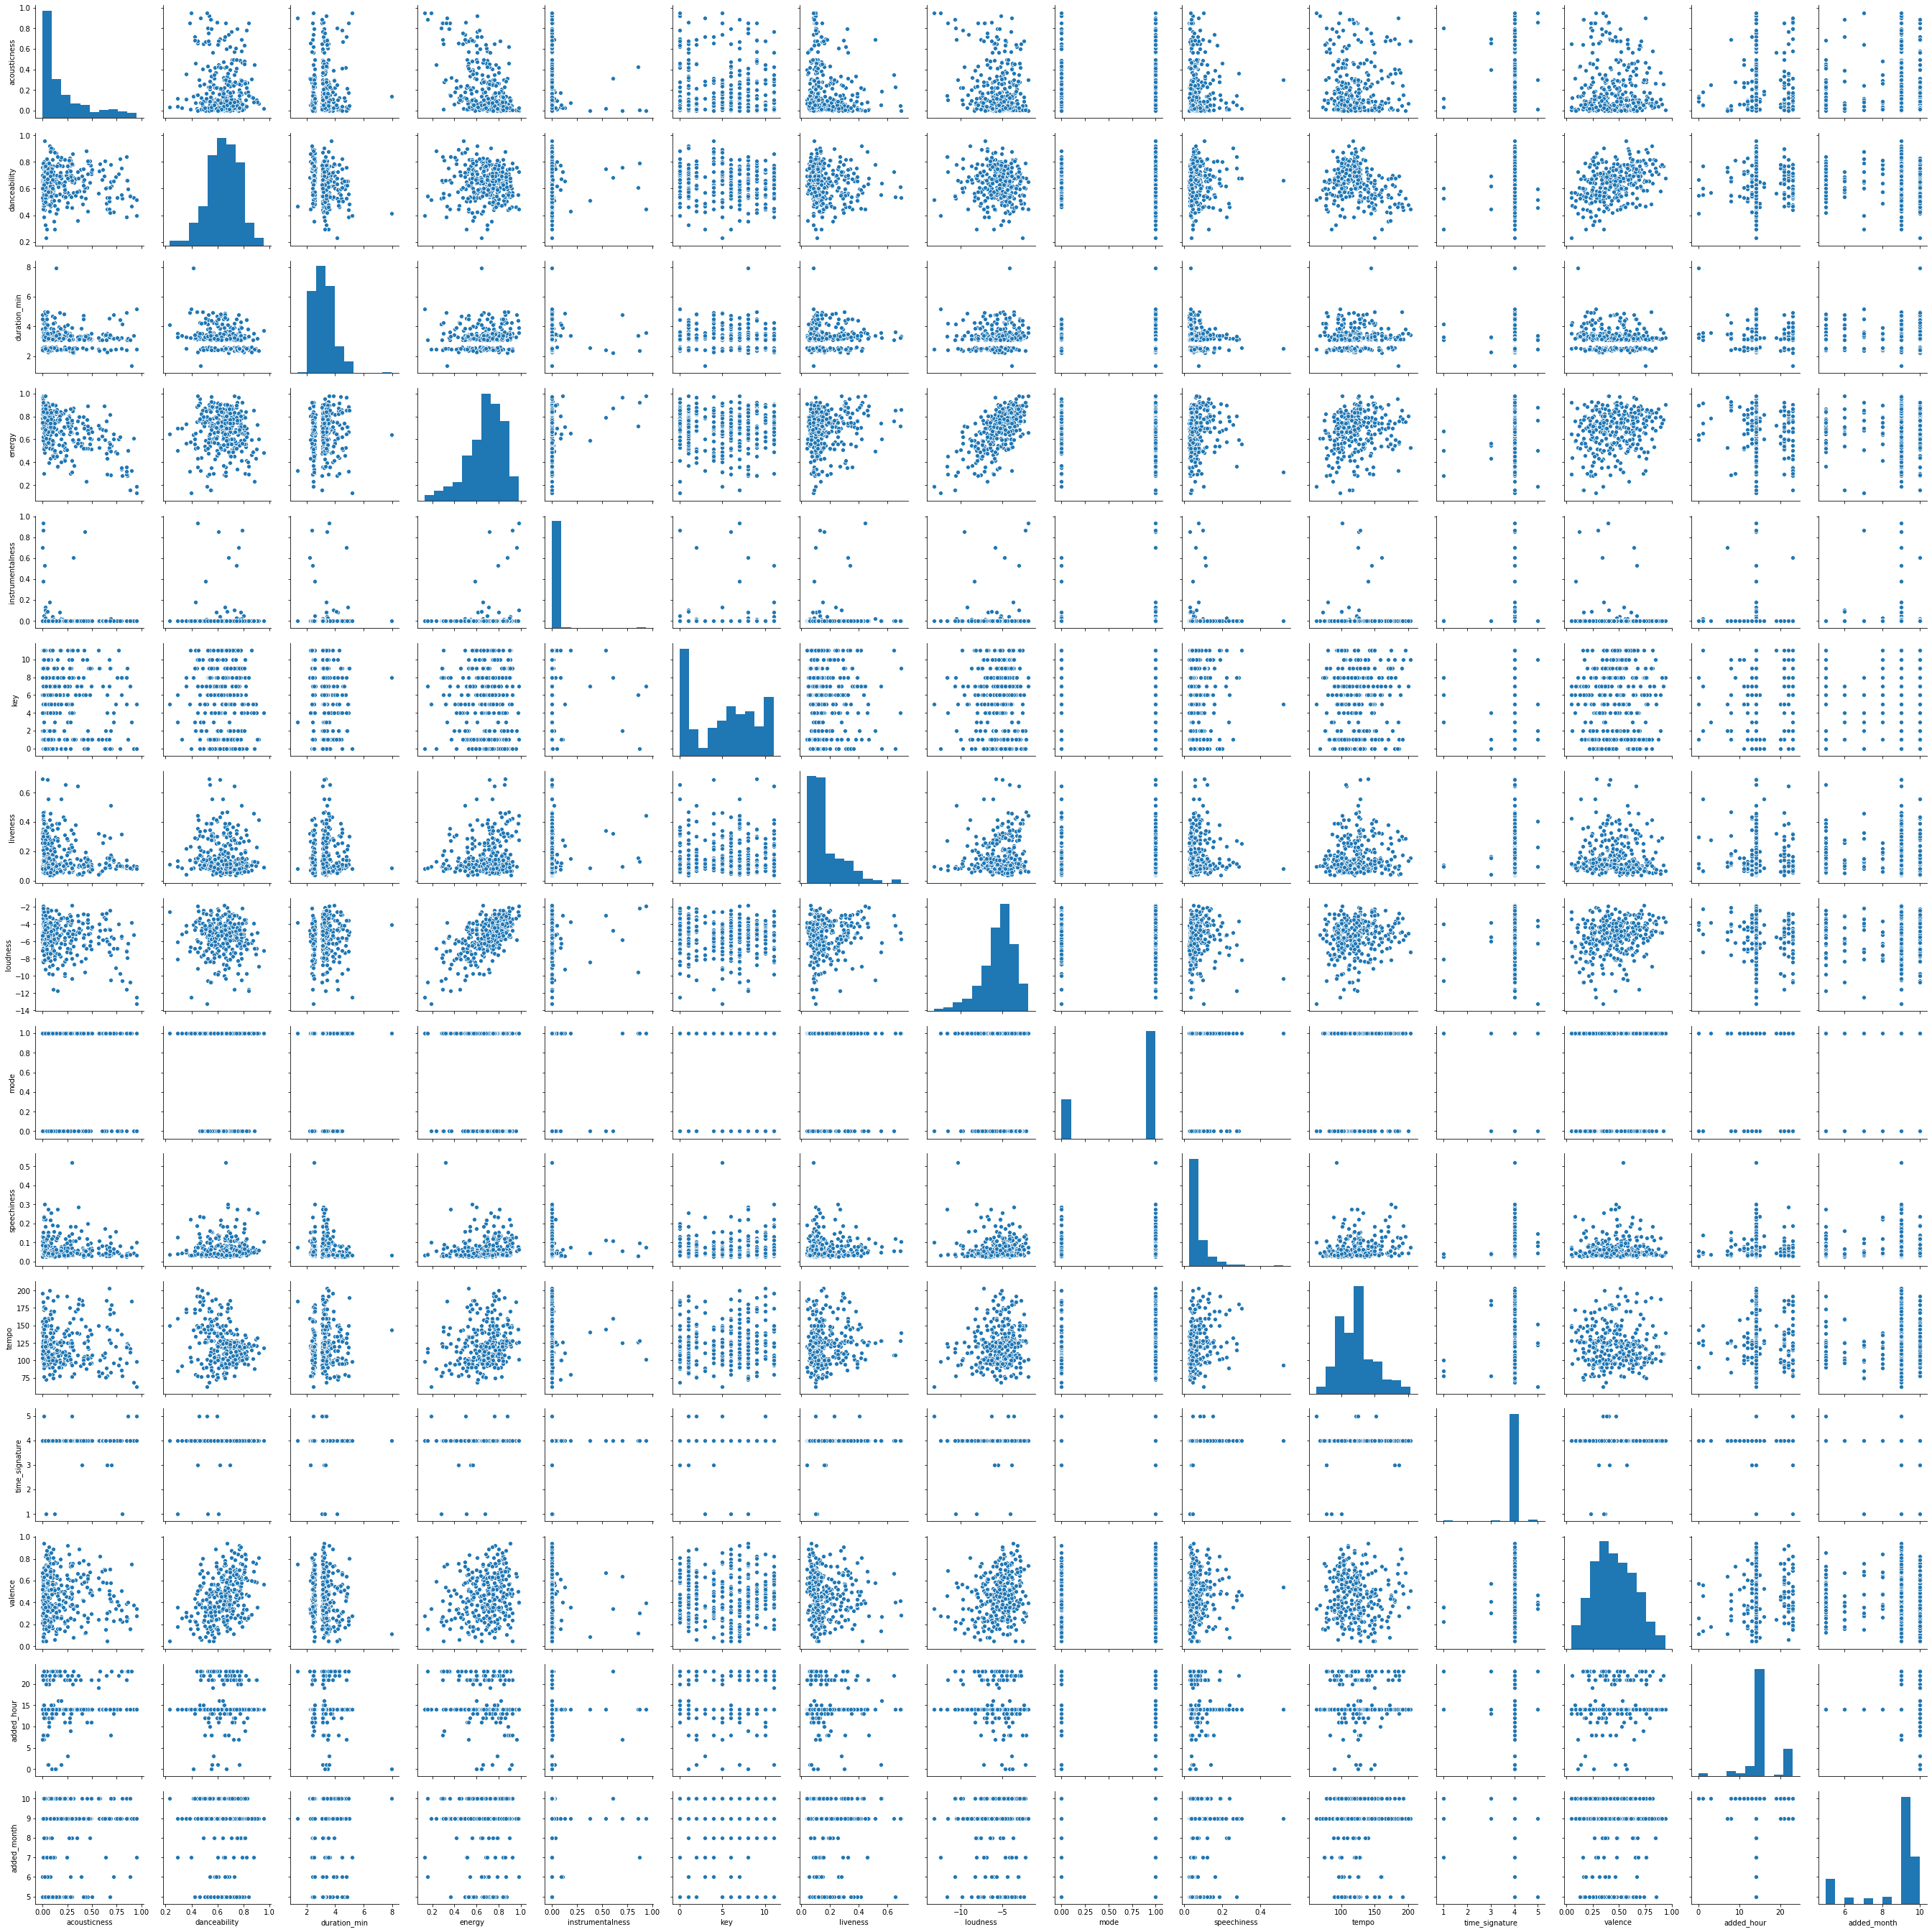

In [15]:
### Checking the distribution of all numerical features

sns.pairplot(df_final_3)

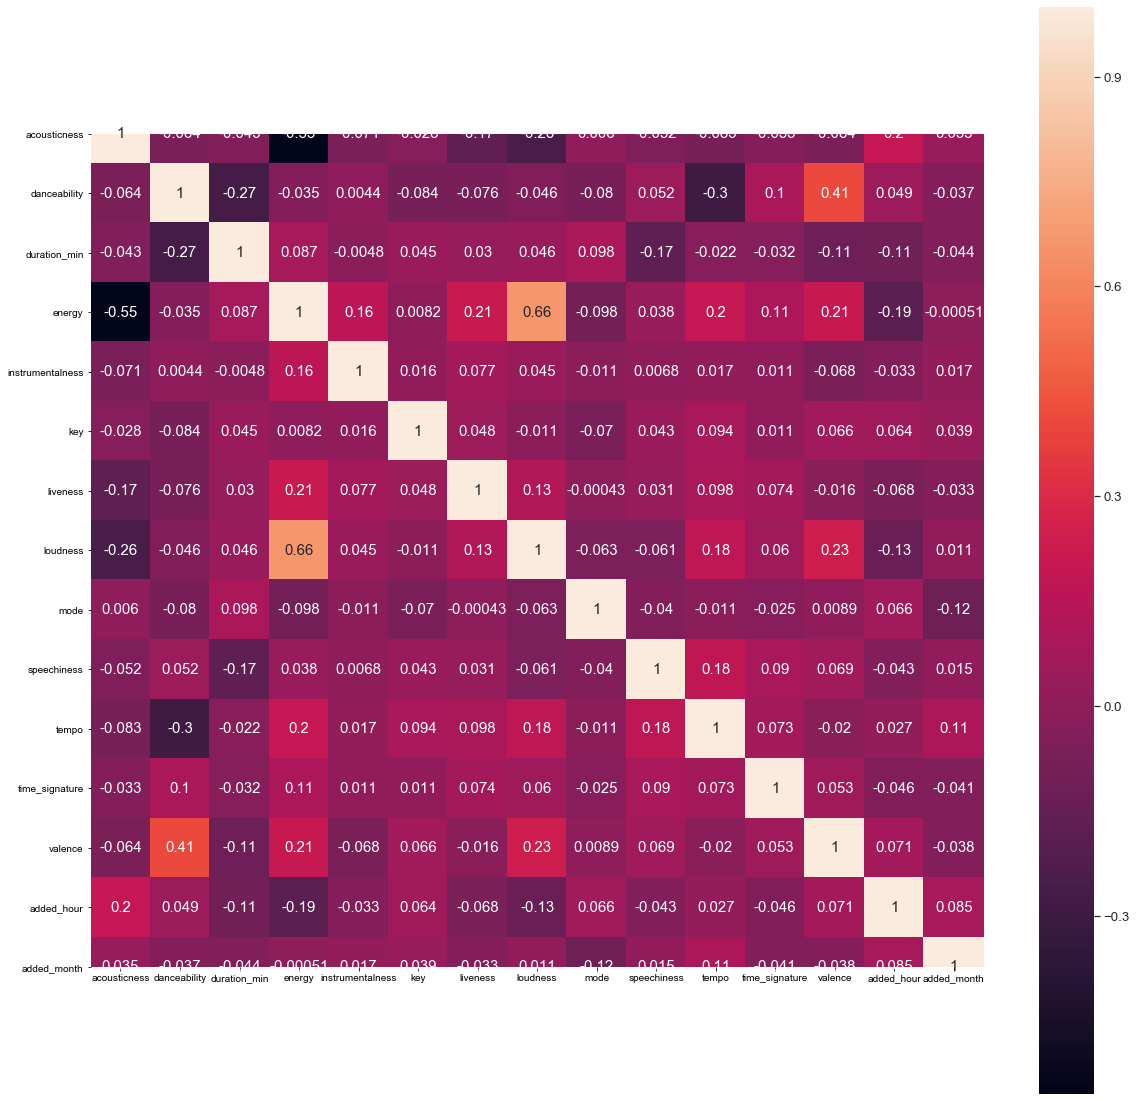

In [16]:
### Creating a heatmap to see the correlation degree between all the continuous features

fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale = 1.2)
sns.heatmap(df_final_3.corr(), vmax=1, square=True, annot=True, annot_kws={"size":15}, ax=ax)

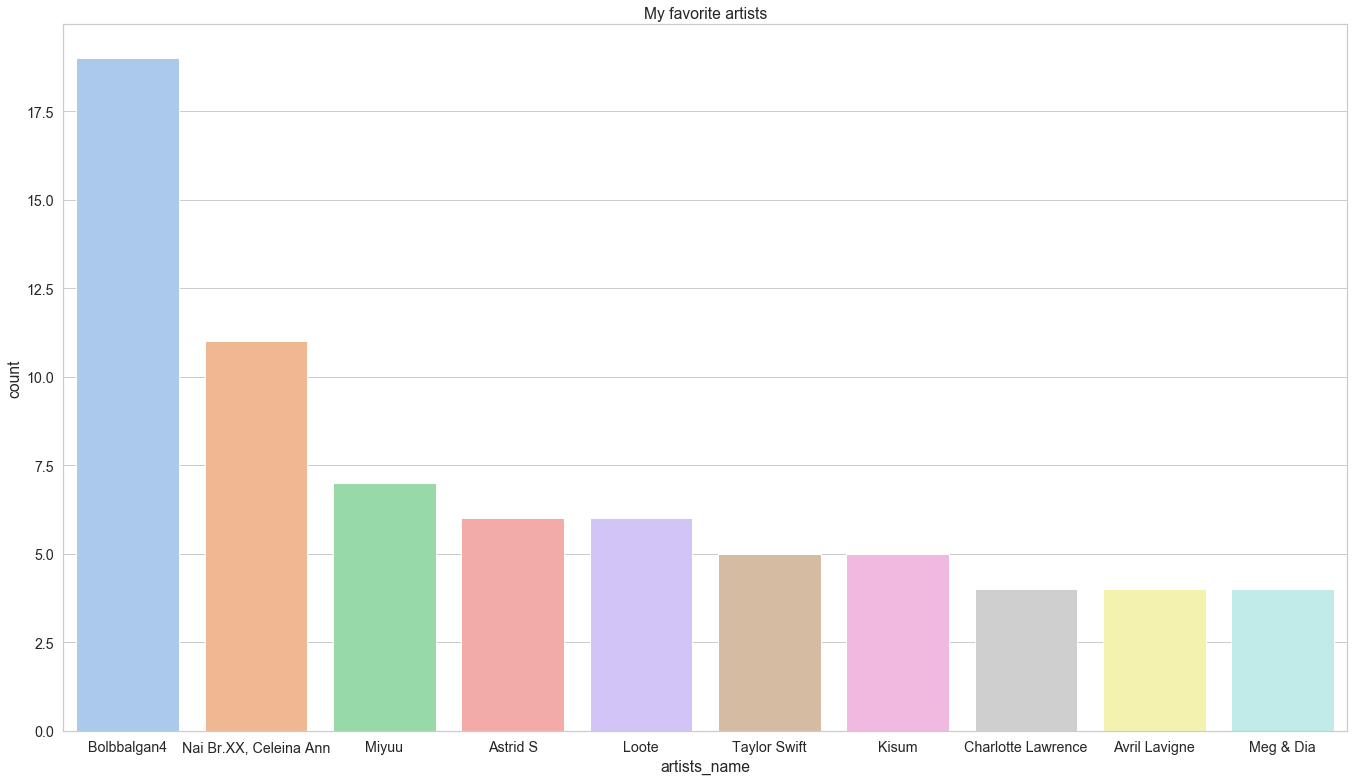

In [17]:
### Analyzing my favorite artists

plt.figure(figsize=(23,13))
sns.set(palette='pastel', font_scale=1.3, style='whitegrid')
sns.countplot(df_final_3['artists'], order=df_final_3['artists'].value_counts()[:10].index)
plt.xlabel('artists_name')
plt.title('My favorite artists')
plt.show()

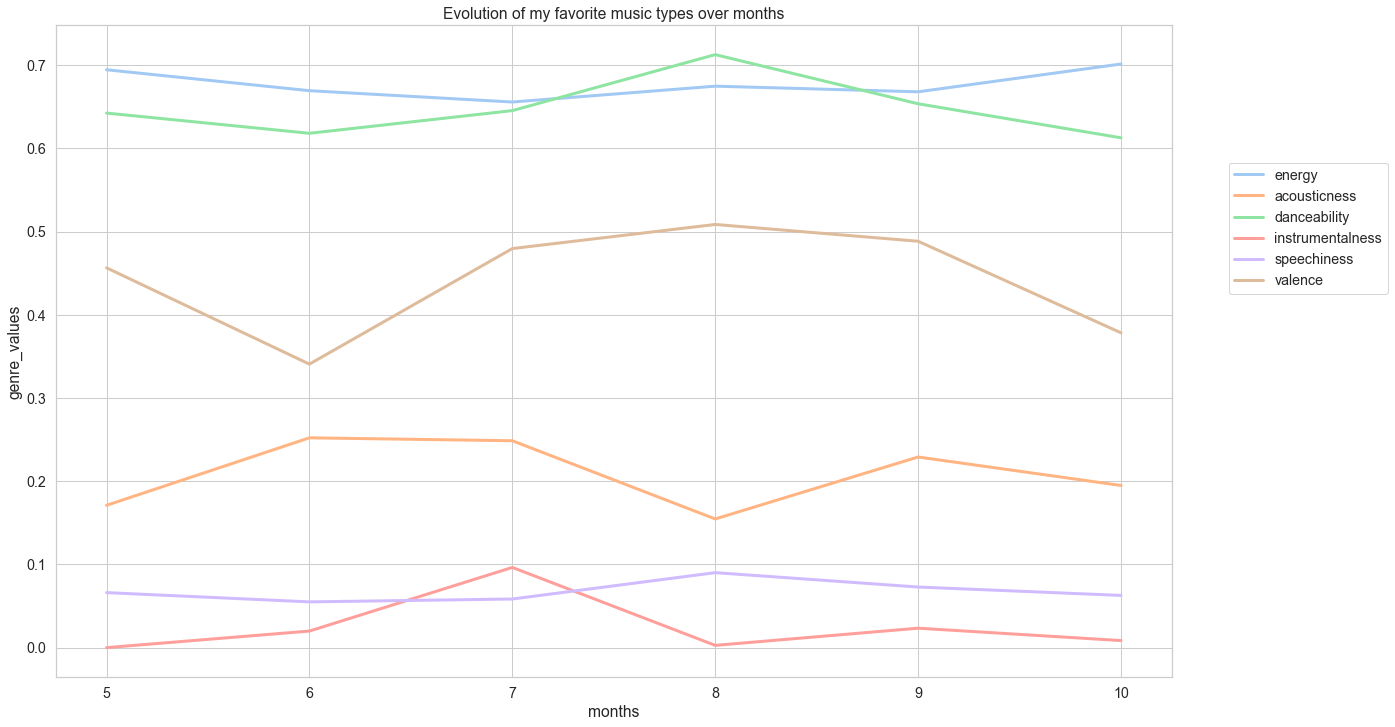

In [18]:
### Analyzing the evolution of my music genre preferences over months

features_to_drop = [
    'duration_min', 'key', 'liveness', 
    'time_signature', 'added_hour', 'tempo',
    'loudness', 'mode'
]

legends = [
    'energy', 'acousticness', 'danceability',
    'instrumentalness', 'speechiness', 'valence'
]

df_agg = (df_final_3.groupby('added_month')
                                .mean()
                                .drop(features_to_drop, axis=1))

plt.figure(figsize=(20, 12))
plt.plot(df_agg['energy'], linewidth=3)
plt.plot(df_agg['acousticness'], linewidth=3)
plt.plot(df_agg['danceability'], linewidth=3)
plt.plot(df_agg['instrumentalness'], linewidth=3)
plt.plot(df_agg['speechiness'], linewidth=3)
plt.plot(df_agg['valence'], linewidth=3)
plt.xlabel('months')
plt.ylabel('genre_values')
plt.title('Evolution of my favorite music types over months')
plt.legend(legends, loc='upper right', bbox_to_anchor=(1.2, 0.8))
plt.show()

Tracks metrics description (according to https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) : 
-  **Energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
-  **Acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
-  **Danceability** : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
-  **Instrumentalness** : Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
-  **Speechiness** : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
-  **Valence** : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

This analysis above shows from May to October that :
-  My music tastes have changed a little (I used to listen more Pop music between July and September before shifting back to more Music based songs, as shown by the overlap between the danceability and energy in this period).
-  My favorite music are dance and pop based (caracterized by a high danceability and energy in the graph).
-  I mostly listen to tracks with good vibes as shown by the values of the Valence metric that are average.
-  It happens that I listen to acoustic songs, mostly Korean Folks actually (i.e Bolbbalgan4).
-  I rarely listen to Rap music as shown by the low values of Speechiness.
-  I rarely listen to music with low instrumentalness, this is because most of the tracks in my playlist are high melody/energy based.

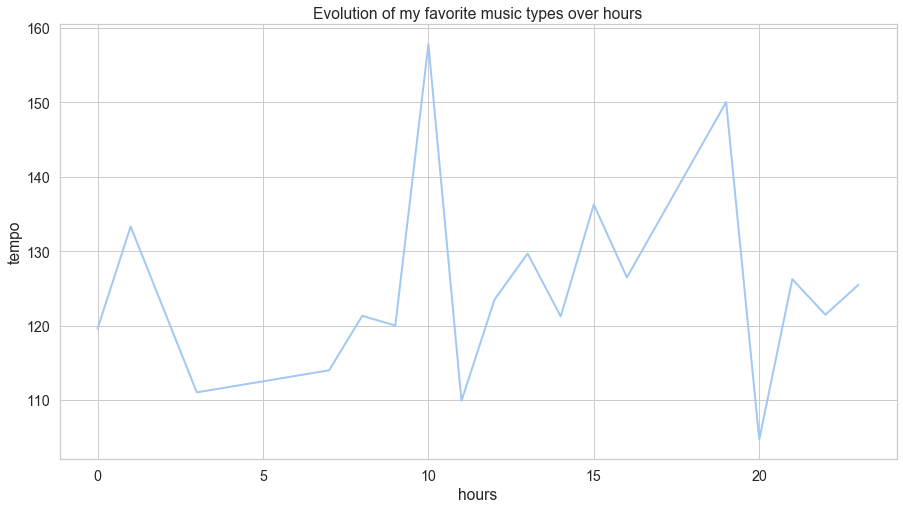

In [19]:
### Analyzing the tempo over hours

df_tempo = (df_final_3.groupby('added_hour')
                                    .mean())

plt.figure(figsize=(15, 8))
plt.plot(df_tempo['tempo'], linewidth=2)
plt.xlabel('hours')
plt.ylabel('tempo')
plt.title('Evolution of my favorite music types over hours')
plt.show()

It seems that globally, I mostly listen to songs with a high BPM (*beats per minute*), this can be explained by the fact that most of the tracks in my Spotify playlist contains EDM songs (house, electro, dance, pop).

We can also notice that I listen to the most energic songs around 10am and 17pm, which are the hours when I'm the most productive in a day. We can also see that I tend to listen to slower songs during nightime (from 8pm to 4am).

### 4. Machine Learning - Unsupervised Learning

We will use a K-Means algorithm to create groups of music based on its energy; acousticness; danceability; instrumentalness; speechiness and valence. This algorithm will allow me to know my current taste in music.

#### 4.1. Data Preprocessing

In [20]:
### Transforming the input features to array

cluster_features = [
    'energy', 'acousticness', 'danceability',
    'instrumentalness', 'speechiness', 'valence'
]

df_cluster = df_final_3[cluster_features]
X = np.array(df_cluster)

### Scaling the data with a MinMaxScaler (as our features don't all follow a Gaussian distribution)

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

#### 4.2. K-Means

We will use the elbow method to find the optimal value of k for the K-Means, then we will apply the algorithm to our data.

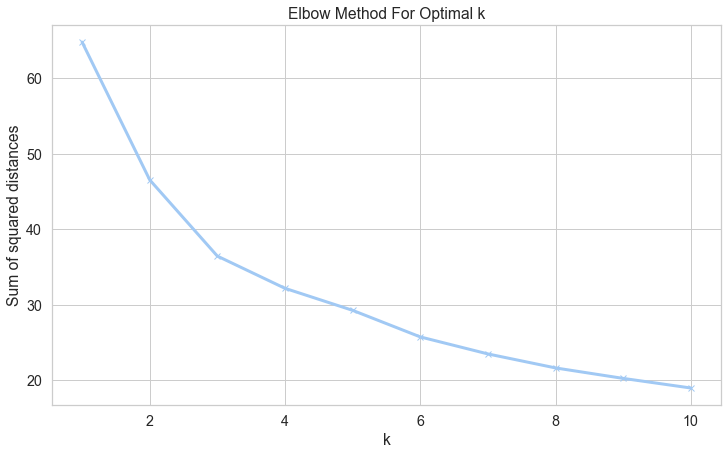

In [21]:
### Using the elbow method to find the optimal value of k

ss_dist = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km = km.fit(X)
    ss_dist.append(km.inertia_)
 
plt.figure(figsize=(12, 7))
plt.plot(K, ss_dist, 'bx-', linewidth=3)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The optimal value for k seems to be 5, so we will create five clusters.

In [22]:
### Applying the k-means to our features

km = KMeans(n_clusters=5, random_state=123)
km.fit(X)
km.cluster_centers_

array([[6.85957697e-01, 1.11192449e-01, 6.87112069e-01, 1.15778856e-02,
        7.85858586e-02, 7.47971461e-01],
       [5.95261537e-01, 1.51552312e-01, 4.52637465e-01, 2.31519543e-02,
        7.49331149e-02, 2.14136632e-01],
       [7.76156591e-01, 7.94251098e-02, 5.49961686e-01, 3.42205484e-02,
        1.04328470e-01, 4.42993637e-01],
       [3.52715970e-01, 8.09842751e-01, 4.68387097e-01, 8.65045739e-05,
        5.28836755e-02, 3.22714226e-01],
       [5.45869429e-01, 4.46391274e-01, 6.90072173e-01, 8.79799177e-04,
        1.34658210e-01, 5.75747322e-01]])

#### 4.3. Principal Component Analysis (PCA)

Now that we have created our clusters, we want to visualize them in a plan. However, it's possible to observe in a plan upon dimension 3 and we are in dimension 6 (because we created our clusters by using six features), so we will have to use PCA to reduce the dimension of our clusters to be able observe them graphically.

In [23]:
### Applying PCA to our data to reduce its dimension from 5 to 3

pca = PCA(n_components=3, random_state=123)
pc = pca.fit_transform(X)

print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.8032833217657057


array([0.40901042, 0.68099394, 0.80328332])

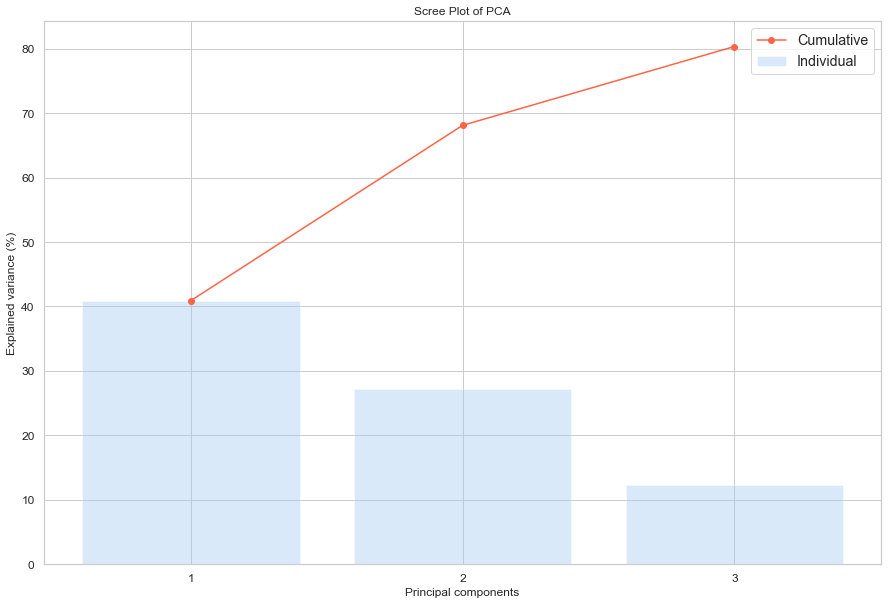

In [24]:
### Creating a Scree Plot to observe the importance of each principal component

df_scree = pd.DataFrame({'Component': ['1','2','3'], 'pc_importance': pca.explained_variance_ratio_})
df_scree['var_cum_sum'] = df_scree['pc_importance'].cumsum()
df_scree

fig, ax = plt.subplots(figsize=(15, 10))

plt.bar(
    range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
    label='Individual', axes=ax, alpha=0.4)

plt.plot(
    range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
    label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Scree Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

Reducing the dimension from 5 to 3 through PCA would allow us to keep around 80% of the total information, which is fine, so we will keep it like this.

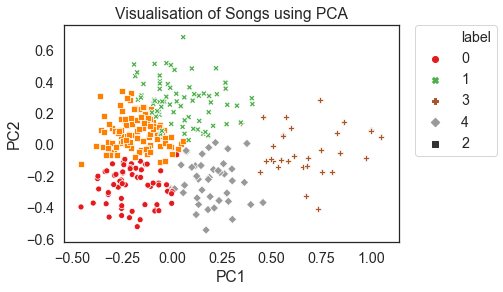

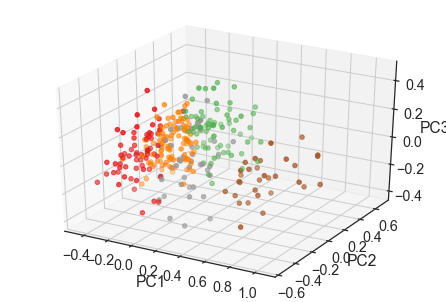

In [25]:
### PCA DataFrame

df_pca = pd.DataFrame(pc)
df_pca.columns = ['PC1', 'PC2', 'PC3']
df_pca['label'] = km.labels_
df_pca.head()

### Visualization with 2 Principal Components

sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

### Visualization with 3 Principal Components

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(
    df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
    c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

#### 4.4. Clusters Analysis

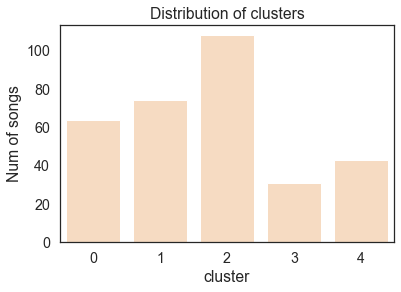

In [26]:
### Checking the number of songs per cluster

df_final_3['cluster'] = km.labels_
df_cluster_size = df_final_3.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='peachpuff')
plt.title('Distribution of clusters')
plt.show()

In [27]:
### Calculate mean of each variable

radar_col = cluster_features + ['cluster']

### Feature average for each cluster as a radar chart

df_radar = df_final_3[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()
df_radar

,cluster,energy,acousticness,danceability,instrumentalness,speechiness,valence
0,0,0.714750,0.106240,0.731156,0.010860,0.062900,0.713813
1,1,0.637568,0.144691,0.561162,0.021717,0.061092,0.236831
2,2,0.791509,0.075976,0.631722,0.032099,0.075643,0.441315
3,3,0.431161,0.771839,0.572581,0.000081,0.050177,0.333845
4,4,0.595535,0.425581,0.733302,0.000825,0.090656,0.559930


In [28]:
### Function to create a Radar plot

def make_radar(row, title, color, dframe, num_clusters):
    """
    Function that allows the use to create a Radar Plot that contains
    the caracteristics of each cluster.
    
    Parameters:
        - row: Elements position in the dataframe.
        - title: Title of the plot.
        - color: Color of the radars.
        - dframe: Input Dataframe.
        - num_clusters: Number of clusters to display.
    """
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2, ceil(num_clusters / 2), row + 1, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values = dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

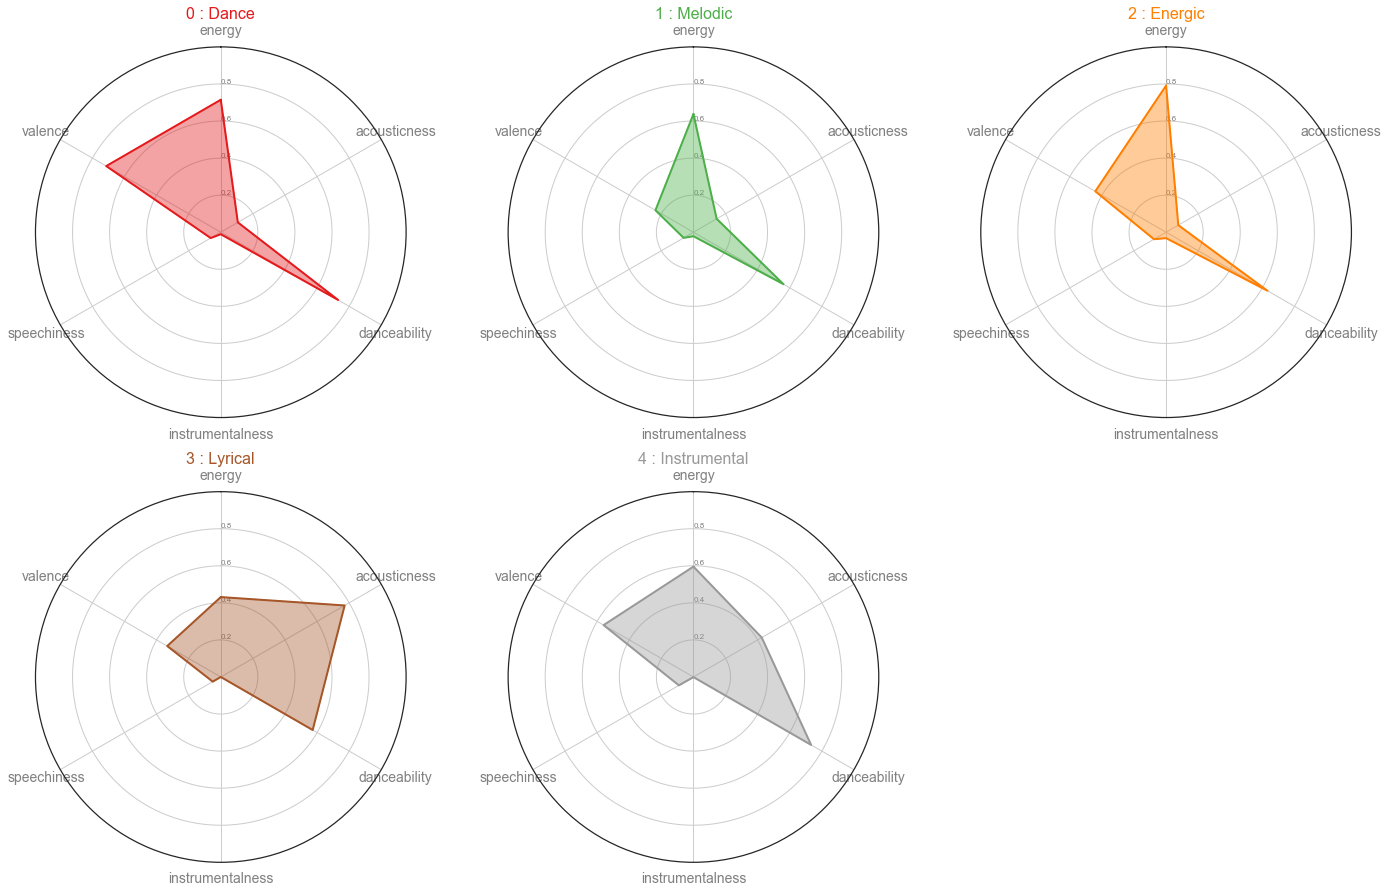

In [29]:
### Creating the Radar plot

# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

# Create cluster name
title_list = ['Dance', 'Melodic', 'Energic', 'Lyrical', 'Instrumental']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(
        row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
        color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))
    
# Show plot
plt.show()

#### 4.5. Songs in each cluster

In [30]:
### DataFrame containing only the artists, songs_names and clusters numbers

feat_cluster = ['song_title', 'artists', 'cluster']
df_cluster_details = df_final_3[feat_cluster]

In [31]:
### Checking songs in cluster 0

cluster_0 = df_cluster_details[df_cluster_details['cluster'] == 0]
cluster_0

,song_title,artists,cluster
1,Choose,Anna Mae,0
22,How You Love Me (feat. Conor Maynard & Snoop D...,"Hardwell,Conor Maynard,Snoop Dogg",0
46,I Got Eyes,"John De Sohn,TILI",0
48,Just Like You (feat. Lake),"HIDDN,Lake",0
49,Nothing Like You (feat. HANA),"Gryffin,DROELOE,HANA",0
51,Lovers + Strangers,Starley,0
62,2002,Anne-Marie,0
89,I Don't Even Smoke Weed,Empress Of,0
93,Waste Time,"ToonSquad,LAV8,BAER",0
96,Single-Minded,Anna Mae,0


In [32]:
### Checking songs in cluster 1

cluster_1 = df_cluster_details[df_cluster_details['cluster'] == 1]
cluster_1

,song_title,artists,cluster
0,I Get You,"Kasbo,Lizzy Land",1
2,Mother,VOICES FROM MARS,1
3,After the fire,"Nai Br.XX, Celeina Ann",1
6,LIGHTS GO OUT,Alisa,1
10,Breathe Again,Alisa,1
15,Gonna Be Alright - Armando Remix,"Tritonal,Mozella,Armando",1
19,Never Change (feat. Gallie Fisher),"Crystal Skies,Gallie Fisher",1
20,Back to You,"Cailee Rae,NATIIVE",1
21,Way that You Do,"tofû,Chloe Farrell",1
25,Warriors,"Paris Blohm,Nevlin,Romysa",1


In [33]:
### Checking songs in cluster 2

cluster_2 = df_cluster_details[df_cluster_details['cluster'] == 2]
cluster_2

,song_title,artists,cluster
5,Beautiful Breakdown,"Nai Br.XX, Celeina Ann",2
7,Take Me Now,Banvox,2
9,Army Of Two,"Nai Br.XX, Celeina Ann",2
14,Gravity - VAANCE Remix,"Cherry Beach,Vaance",2
16,Radio Silence - Ryan Riback Remix,"R3HAB,Jocelyn Alice,Ryan Riback",2
17,Off My Mind,"Tom Ferry,Lisa Ajax",2
18,Lost At Sea,Dante Klein,2
23,Feels Like,"Vicetone,Laur",2
24,Give Me a Sign,Steyyx,2
27,Yellow (feat. Liv Dawson),"Oliver Nelson,Tobtok,Liv Dawson",2


In [34]:
### Checking songs in cluster 3

cluster_3 = df_cluster_details[df_cluster_details['cluster'] == 3]
cluster_3

,song_title,artists,cluster
4,Lay It All On Me,"Nai Br.XX, Celeina Ann",3
8,Give You The World C&T ver.,"Nai Br.XX, Celeina Ann",3
12,Whispering My Love,"Nai Br.XX, Celeina Ann",3
13,The Loneliest Girl,"Nai Br.XX, Celeina Ann",3
54,More of Me,Lydia Halloway,3
58,Deep Blue,"William Black,Monika Santucci",3
74,Navy Blue,Charlotte Lawrence,3
76,Sidelove,Astrid S,3
77,Years,Astrid S,3
78,Favorite Part Of Me,Astrid S,3


In [35]:
### Checking songs in cluster 4

cluster_4 = df_cluster_details[df_cluster_details['cluster'] == 4]
cluster_4

,song_title,artists,cluster
11,Round & Laundry,"Nai Br.XX, Celeina Ann",4
39,Kind of Blue,Hellberg,4
61,Good Thing (with Kehlani),"Zedd,Kehlani",4
64,Lean Back,Ruhde,4
67,SOS,"Avicii,Aloe Blacc",4
68,This Is On You,Maisie Peters,4
69,Stuck (feat. Tove Styrke) - Kuur x Kbubs x DCB...,"Lost Kings,Tove Styrke,Kuur,Kbubs,DCB",4
71,SOS (feat. Aloe Blacc),"Avicii,Aloe Blacc",4
73,Why Do You Love Me,Charlotte Lawrence,4
90,Just The Same,Charlotte Lawrence,4
